# Traffic Volume Analysis - Corridor 102

This notebook analyzes traffic volume data from various intersections along Corridor 102 throughout different times of the day:
- **Morning**: 6:00 AM - 12:00 PM
- **Afternoon**: 12:00 PM - 6:00 PM  
- **Night**: 6:00 PM - 6:00 AM

## Import Required Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from datetime import datetime

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')

# Define time periods
MORNING_START, MORNING_END = 6, 12  # 6 AM - 12 PM
AFTERNOON_START, AFTERNOON_END = 12, 18  # 12 PM - 6 PM
# Night is 18-24 (6 PM - midnight) and 0-6 (midnight - 6 AM)

# Get all CSV files in the volume directory
data_dir = Path('data/volume')
csv_files = sorted(list(data_dir.glob('*.csv')))

print(f"Found {len(csv_files)} intersection files:")
for file in csv_files:
    print(f"  - {file.name}")
    
# Intersection names mapping
intersection_names = {
    '102_a.csv': 'Intersection A',
    '102_been_3.csv': 'Been',
    '102_c_7.csv': 'Intersection C',
    '102_elm_2.csv': 'Elm',
    '102_greenhouse_1.csv': 'Greenhouse',
    '102_i_4.csv': 'Intersection I',
    '102_j_8.csv': 'Intersection J',
    '102_moberly.csv': 'Moberly',
    '102_p_9.csv': 'Intersection P',
    '102_walton_5.csv': 'Walton'
}

# Choose which date to analyze (set to pd.Timestamp('YYYY-MM-DD') to override)
TARGET_DATE = None
print(f"Target date: {TARGET_DATE if TARGET_DATE else 'first available per file'}")

Found 10 intersection files:
  - 102_a.csv
  - 102_been_3.csv
  - 102_c_7.csv
  - 102_elm_2.csv
  - 102_greenhouse_1.csv
  - 102_i_4.csv
  - 102_j_8.csv
  - 102_moberly.csv
  - 102_p_9.csv
  - 102_walton_5.csv
Target date: first available per file


## Data Loading and Processing Function

In [68]:
def load_and_process_intersection_data(file_path, target_date=None):
    """Load and process intersection data from CSV file."""
    df = pd.read_csv(
        file_path,
        skiprows=2,
        converters={'TIME': str},
        index_col=False
    )

    # Normalize DATE/TIME columns
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
    df['TIME'] = df['TIME'].str.replace('="', '', regex=False).str.replace('"', '', regex=False)
    df['TIME'] = df['TIME'].str.zfill(4)

    # Filter to a single date to avoid stacking multiple days of data
    selected_date = target_date if target_date is not None else df['DATE'].min()
    df = df[df['DATE'] == selected_date].copy()

    df['HOUR'] = df['TIME'].str[:2].astype(int)

    direction_columns = ['NBL', 'NBT', 'NBR', 'SBL', 'SBT', 'SBR',
                         'EBL', 'EBT', 'EBR', 'WBL', 'WBT', 'WBR']

    for col in direction_columns:
        if col in df.columns:
            numeric_series = pd.to_numeric(df[col].replace('*', pd.NA), errors='coerce')
            df[col] = numeric_series.fillna(0)

    existing_cols = [col for col in direction_columns if col in df.columns]
    df['TOTAL_VOLUME'] = df[existing_cols].sum(axis=1)
    df['SELECTED_DATE'] = selected_date

    return df

def filter_by_time_period(df, period='morning'):
    """Filter dataframe by time period."""
    if period == 'morning':
        return df[(df['HOUR'] >= MORNING_START) & (df['HOUR'] < MORNING_END)]
    if period == 'afternoon':
        return df[(df['HOUR'] >= AFTERNOON_START) & (df['HOUR'] < AFTERNOON_END)]
    if period == 'night':
        return df[(df['HOUR'] >= 18) | (df['HOUR'] < 6)]
    return df

def aggregate_by_hour(df):
    """Aggregate traffic volume by hour."""
    return df.groupby('HOUR', as_index=False)['TOTAL_VOLUME'].sum()

print("Functions defined successfully!")

Functions defined successfully!


## Debug: Check Data Loading

In [69]:
# Test loading one file to see what's happening
test_file = csv_files[0]
print(f"Testing with: {test_file.name}\n")

# Load the data for the configured date
test_df = load_and_process_intersection_data(test_file, TARGET_DATE)

if test_df.empty:
    raise ValueError("No data available for the selected date. Try adjusting TARGET_DATE.")

selected_date = test_df['SELECTED_DATE'].iloc[0]
print(f"Using data for date: {selected_date.date()}\n")
print(f"DataFrame shape: {test_df.shape}")
print(f"Columns: {test_df.columns.tolist()}\n")

print("First five rows of DATE / TIME / INTID / HOUR / TOTAL_VOLUME:")
print(test_df[['DATE', 'TIME', 'INTID', 'HOUR', 'TOTAL_VOLUME']].head())

print(f"\nUnique hours in data (first 12 shown): {sorted(test_df['HOUR'].unique())[:12]}")
print(f"\nTotal volume statistics:")
print(test_df['TOTAL_VOLUME'].describe())

# Check morning data specifically
morning_test = test_df[(test_df['HOUR'] >= 6) & (test_df['HOUR'] < 12)]
print(f"\nMorning rows: {len(morning_test)}")
print(f"Morning total volume: {morning_test['TOTAL_VOLUME'].sum()}")
print("\nSample morning data:")
print(morning_test[['DATE', 'TIME', 'INTID', 'HOUR', 'TOTAL_VOLUME']].head())

Testing with: 102_a.csv

Using data for date: 2025-10-11

DataFrame shape: (96, 18)
Columns: ['DATE', 'TIME', 'INTID', 'NBL', 'NBT', 'NBR', 'SBL', 'SBT', 'SBR', 'EBL', 'EBT', 'EBR', 'WBL', 'WBT', 'WBR', 'HOUR', 'TOTAL_VOLUME', 'SELECTED_DATE']

First five rows of DATE / TIME / INTID / HOUR / TOTAL_VOLUME:
        DATE  TIME  INTID  HOUR  TOTAL_VOLUME
0 2025-10-11  0000      6     0         134.0
1 2025-10-11  0015      6     0         148.0
2 2025-10-11  0030      6     0         106.0
3 2025-10-11  0045      6     0         102.0
4 2025-10-11  0100      6     1          93.0

Unique hours in data (first 12 shown): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]

Total volume statistics:
count     96.000000
mean     410.125000
std      259.395339
min       26.000000
25%      145.250000
50%      455.500000
75%      653.250000
max      769.000000
Name: TOTAL_VOLUME, dtype: float

## Morning Traffic Volume (6:00 AM - 12:00 PM)

Visualizing the total vehicle volume at each intersection during morning hours.

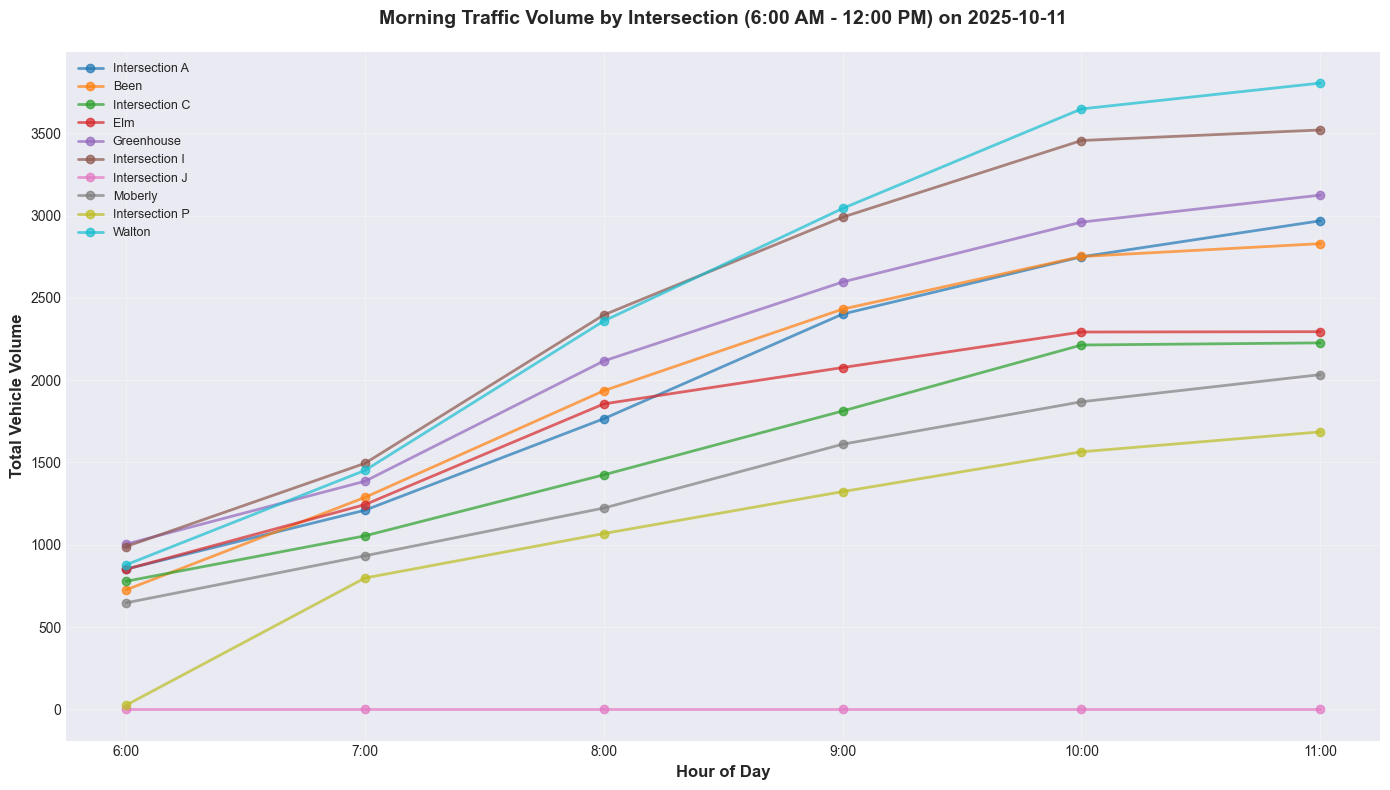


Morning Traffic Summary:
------------------------------------------------------------
Intersection A            | Total:  11949 | Avg/Hour:   1992
Been                      | Total:  11964 | Avg/Hour:   1994
Intersection C            | Total:   9511 | Avg/Hour:   1585
Elm                       | Total:  10616 | Avg/Hour:   1769
Greenhouse                | Total:  13190 | Avg/Hour:   2198
Intersection I            | Total:  14850 | Avg/Hour:   2475
Intersection J            | Total:      0 | Avg/Hour:      0
Moberly                   | Total:   8317 | Avg/Hour:   1386
Intersection P            | Total:   6465 | Avg/Hour:   1078
Walton                    | Total:  15189 | Avg/Hour:   2532


In [70]:
# Process morning data for all intersections
morning_data = {}
analysis_date = None

for file in csv_files:
    df = load_and_process_intersection_data(file, TARGET_DATE)
    if df.empty:
        print(f"Skipping {file.name} (no data for selected date)")
        continue

    if analysis_date is None and not df.empty:
        analysis_date = df['SELECTED_DATE'].iloc[0].date()

    morning_df = filter_by_time_period(df, 'morning')
    hourly_data = aggregate_by_hour(morning_df)

    intersection_name = intersection_names.get(file.name, file.stem)
    morning_data[intersection_name] = hourly_data

fig, ax = plt.subplots(figsize=(14, 8))

for intersection_name, data in morning_data.items():
    ax.plot(data['HOUR'], data['TOTAL_VOLUME'], marker='o',
            linewidth=2, label=intersection_name, alpha=0.7)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Vehicle Volume', fontsize=12, fontweight='bold')
title_suffix = f" on {analysis_date}" if analysis_date else ''
ax.set_title(f'Morning Traffic Volume by Intersection (6:00 AM - 12:00 PM){title_suffix}',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(MORNING_START, MORNING_END))
ax.set_xticklabels([f'{h}:00' for h in range(MORNING_START, MORNING_END)])

plt.tight_layout()
plt.show()

print("\nMorning Traffic Summary:")
print("-" * 60)
for intersection_name, data in morning_data.items():
    total = data['TOTAL_VOLUME'].sum()
    avg = data['TOTAL_VOLUME'].mean()
    print(f"{intersection_name:25s} | Total: {total:6.0f} | Avg/Hour: {avg:6.0f}")

## Afternoon Traffic Volume (12:00 PM - 6:00 PM)

Visualizing the total vehicle volume at each intersection during afternoon hours.

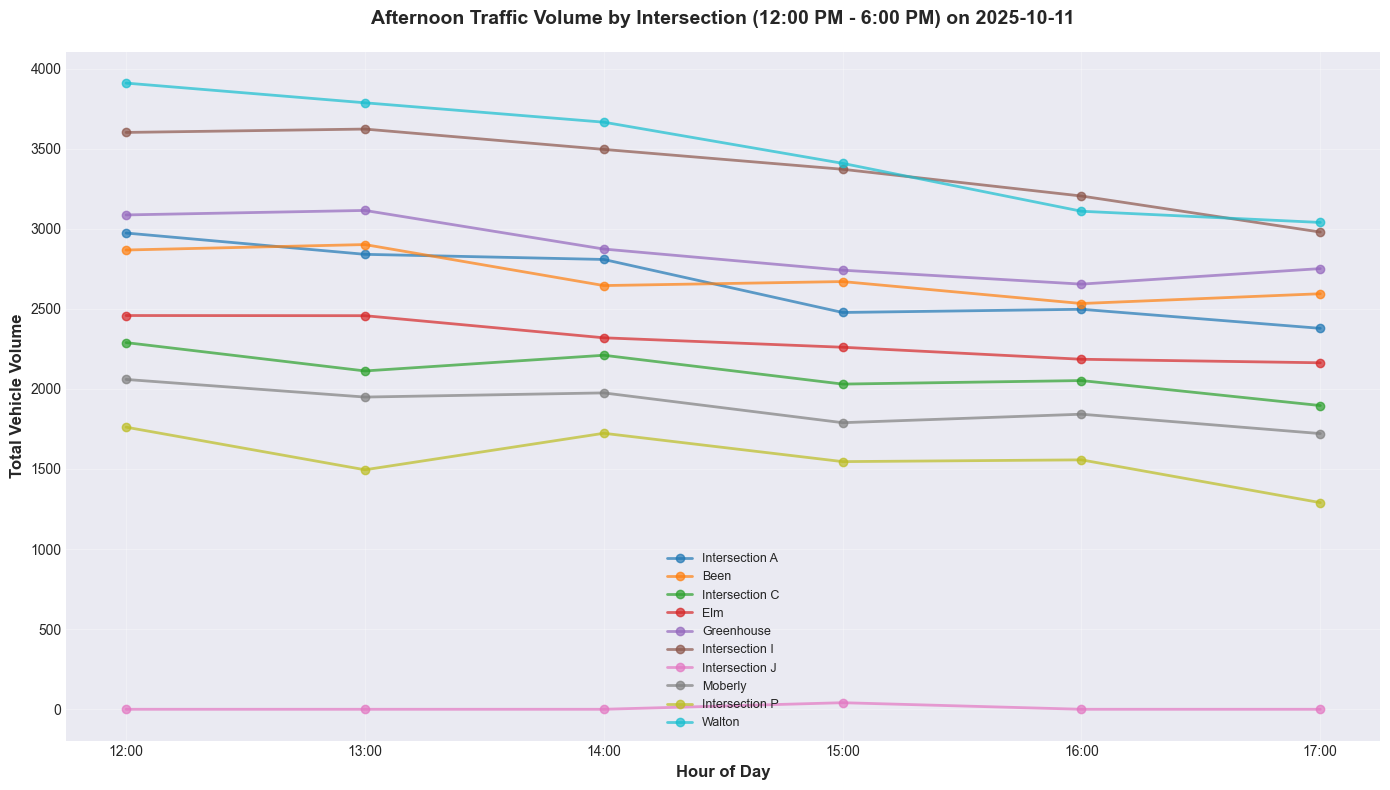


Afternoon Traffic Summary:
------------------------------------------------------------
Intersection A            | Total:  15973 | Avg/Hour:   2662
Been                      | Total:  16210 | Avg/Hour:   2702
Intersection C            | Total:  12589 | Avg/Hour:   2098
Elm                       | Total:  13842 | Avg/Hour:   2307
Greenhouse                | Total:  17219 | Avg/Hour:   2870
Intersection I            | Total:  20272 | Avg/Hour:   3379
Intersection J            | Total:     41 | Avg/Hour:      7
Moberly                   | Total:  11335 | Avg/Hour:   1889
Intersection P            | Total:   9372 | Avg/Hour:   1562
Walton                    | Total:  20916 | Avg/Hour:   3486


In [71]:
# Process afternoon data for all intersections
afternoon_data = {}
analysis_date = None

for file in csv_files:
    df = load_and_process_intersection_data(file, TARGET_DATE)
    if df.empty:
        print(f"Skipping {file.name} (no data for selected date)")
        continue

    if analysis_date is None:
        analysis_date = df['SELECTED_DATE'].iloc[0].date()

    afternoon_df = filter_by_time_period(df, 'afternoon')
    hourly_data = aggregate_by_hour(afternoon_df)

    intersection_name = intersection_names.get(file.name, file.stem)
    afternoon_data[intersection_name] = hourly_data

fig, ax = plt.subplots(figsize=(14, 8))

for intersection_name, data in afternoon_data.items():
    ax.plot(data['HOUR'], data['TOTAL_VOLUME'], marker='o',
            linewidth=2, label=intersection_name, alpha=0.7)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Vehicle Volume', fontsize=12, fontweight='bold')
title_suffix = f" on {analysis_date}" if analysis_date else ''
ax.set_title(f'Afternoon Traffic Volume by Intersection (12:00 PM - 6:00 PM){title_suffix}',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(AFTERNOON_START, AFTERNOON_END))
ax.set_xticklabels([f'{h}:00' for h in range(AFTERNOON_START, AFTERNOON_END)])

plt.tight_layout()
plt.show()

print("\nAfternoon Traffic Summary:")
print("-" * 60)
for intersection_name, data in afternoon_data.items():
    total = data['TOTAL_VOLUME'].sum()
    avg = data['TOTAL_VOLUME'].mean()
    print(f"{intersection_name:25s} | Total: {total:6.0f} | Avg/Hour: {avg:6.0f}")

## Night Traffic Volume (6:00 PM - 6:00 AM)

Visualizing the total vehicle volume at each intersection during night hours.

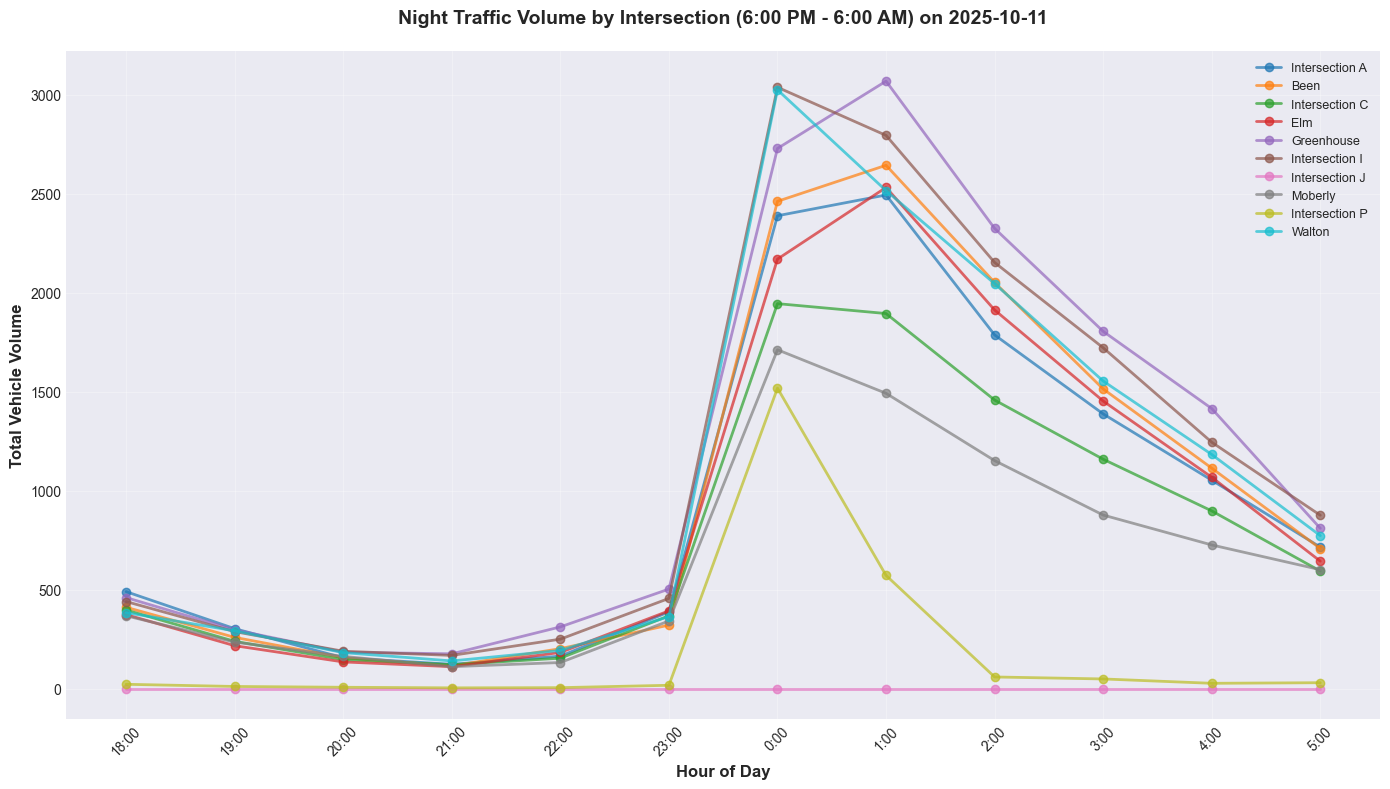


Night Traffic Summary:
------------------------------------------------------------
Intersection A            | Total:  11450 | Avg/Hour:    954
Been                      | Total:  11958 | Avg/Hour:    996
Intersection C            | Total:   9375 | Avg/Hour:    781
Elm                       | Total:  11193 | Avg/Hour:    933
Greenhouse                | Total:  14085 | Avg/Hour:   1174
Intersection I            | Total:  13620 | Avg/Hour:   1135
Intersection J            | Total:      0 | Avg/Hour:      0
Moberly                   | Total:   7911 | Avg/Hour:    659
Intersection P            | Total:   2321 | Avg/Hour:    193
Walton                    | Total:  12652 | Avg/Hour:   1054


In [72]:
# Process night data for all intersections
night_data = {}
analysis_date = None

for file in csv_files:
    df = load_and_process_intersection_data(file, TARGET_DATE)
    if df.empty:
        print(f"Skipping {file.name} (no data for selected date)")
        continue

    if analysis_date is None:
        analysis_date = df['SELECTED_DATE'].iloc[0].date()

    night_df = filter_by_time_period(df, 'night')
    hourly_data = aggregate_by_hour(night_df)

    intersection_name = intersection_names.get(file.name, file.stem)
    night_data[intersection_name] = hourly_data

fig, ax = plt.subplots(figsize=(14, 8))

for intersection_name, data in night_data.items():
    data_sorted = data.sort_values('HOUR')
    ax.plot(range(len(data_sorted)), data_sorted['TOTAL_VOLUME'],
            marker='o', linewidth=2, label=intersection_name, alpha=0.7)

ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Vehicle Volume', fontsize=12, fontweight='bold')
title_suffix = f" spanning {analysis_date} night" if analysis_date else ''
ax.set_title(f'Night Traffic Volume by Intersection (6:00 PM - 6:00 AM){(" on " + str(analysis_date)) if analysis_date else ""}',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)

night_hours = list(range(18, 24)) + list(range(0, 6))
ax.set_xticks(range(len(night_hours)))
ax.set_xticklabels([f'{h}:00' for h in night_hours], rotation=45)

plt.tight_layout()
plt.show()

print("\nNight Traffic Summary:")
print("-" * 60)
for intersection_name, data in night_data.items():
    total = data['TOTAL_VOLUME'].sum()
    avg = data['TOTAL_VOLUME'].mean()
    print(f"{intersection_name:25s} | Total: {total:6.0f} | Avg/Hour: {avg:6.0f}")

## Full-Day Traffic Trends (24 Hours)

Aggregated hourly vehicle volume across the selected day for every intersection.

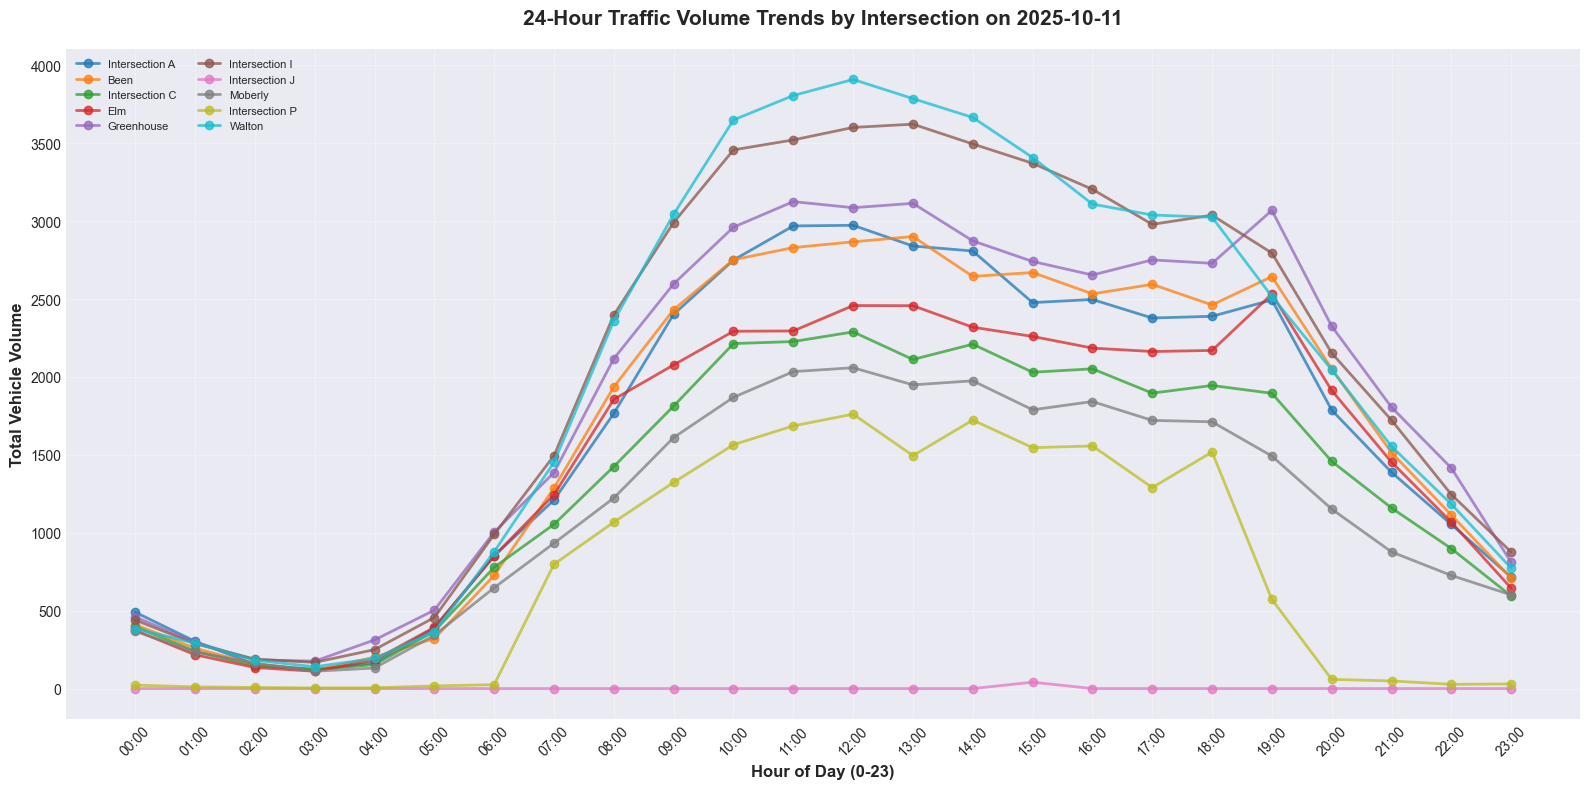


24-Hour Traffic Summary:
------------------------------------------------------------
Intersection A            | Total:  39372 | Peak Hour: 12:00 (  2973)
Been                      | Total:  40132 | Peak Hour: 13:00 (  2901)
Intersection C            | Total:  31475 | Peak Hour: 12:00 (  2289)
Elm                       | Total:  35651 | Peak Hour: 19:00 (  2532)
Greenhouse                | Total:  44494 | Peak Hour: 11:00 (  3125)
Intersection I            | Total:  48742 | Peak Hour: 13:00 (  3622)
Intersection J            | Total:     41 | Peak Hour: 15:00 (    41)
Moberly                   | Total:  27563 | Peak Hour: 12:00 (  2059)
Intersection P            | Total:  18158 | Peak Hour: 12:00 (  1761)
Walton                    | Total:  48757 | Peak Hour: 12:00 (  3909)


In [73]:
# Aggregate full-day hourly trends
full_day_data = {}
analysis_date = None
hours = list(range(24))

for file in csv_files:
    df = load_and_process_intersection_data(file, TARGET_DATE)
    if df.empty:
        print(f"Skipping {file.name} (no data for selected date)")
        continue

    if analysis_date is None:
        analysis_date = df['SELECTED_DATE'].iloc[0].date()

    hourly_data = aggregate_by_hour(df)
    hourly_data = hourly_data.set_index('HOUR').reindex(hours, fill_value=0).reset_index()

    intersection_name = intersection_names.get(file.name, file.stem)
    full_day_data[intersection_name] = hourly_data

if not full_day_data:
    raise ValueError("No intersections had data for the selected date")

fig, ax = plt.subplots(figsize=(16, 8))

for intersection_name, data in full_day_data.items():
    ax.plot(data['HOUR'], data['TOTAL_VOLUME'], marker='o', linewidth=2,
            label=intersection_name, alpha=0.75)

ax.set_xlabel('Hour of Day (0-23)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Vehicle Volume', fontsize=12, fontweight='bold')
summary_suffix = f" on {analysis_date}" if analysis_date else ''
ax.set_title(f'24-Hour Traffic Volume Trends by Intersection{summary_suffix}',
             fontsize=15, fontweight='bold', pad=18)
ax.set_xticks(range(0, 24))
ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45)
ax.legend(loc='upper left', fontsize=8, ncol=2, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n24-Hour Traffic Summary:")
print("-" * 60)
for intersection_name, data in full_day_data.items():
    total = data['TOTAL_VOLUME'].sum()
    peak_hour = data.loc[data['TOTAL_VOLUME'].idxmax(), 'HOUR']
    peak_value = data['TOTAL_VOLUME'].max()
    print(f"{intersection_name:25s} | Total: {total:6.0f} | Peak Hour: {peak_hour:02d}:00 ({peak_value:6.0f})")